In [1]:
import datetime as dt

import numpy as np

import algotrading_v40.data_accessors.cleaned as dac
import algotrading_v40.data_selectors.cusum as ds_c
import algotrading_v40.structures.date_range as sdr
import algotrading_v40.structures.instrument_desc as sid

In [2]:
data = dac.get_cleaned_data(
  [
    sid.EquityDesc(symbol="TRENT", market=sid.Market.INDIAN_MARKET),
    sid.EquityDesc(symbol="HDFCBANK", market=sid.Market.INDIAN_MARKET),
    sid.EquityDesc(symbol="GRASIM", market=sid.Market.INDIAN_MARKET),
    sid.EquityDesc(symbol="ICICIBANK", market=sid.Market.INDIAN_MARKET),
  ],
  sdr.DateRange(dt.date(2021, 1, 1), dt.date(2021, 4, 10)),
)
data._instrument_desc_to_df_list

{EquityDesc(market=<Market.INDIAN_MARKET: 'indian_market'>, symbol='TRENT'): [                                    open    high     low   close  volume
  bar_close_timestamp                                                     
  2021-01-01 03:45:59.999000+00:00  690.90  691.95  688.40  689.05    1831
  2021-01-01 03:46:59.999000+00:00  689.60  690.75  688.05  689.50    1279
  2021-01-01 03:47:59.999000+00:00  689.50  689.50  688.30  689.50     588
  2021-01-01 03:48:59.999000+00:00  689.50  691.00  689.30  690.30    2465
  2021-01-01 03:49:59.999000+00:00  690.30  690.65  689.50  690.15    1548
  ...                                  ...     ...     ...     ...     ...
  2021-04-09 09:55:59.999000+00:00  727.75  729.00  727.75  728.65    1075
  2021-04-09 09:56:59.999000+00:00  727.80  728.90  727.75  728.00    2126
  2021-04-09 09:57:59.999000+00:00  728.00  728.30  727.00  728.05    1081
  2021-04-09 09:58:59.999000+00:00  728.30  728.35  728.00  728.00     432
  2021-04-09 09:59:59.99

In [3]:
df = data.get_full_df_for_instrument_desc(
  sid.EquityDesc(symbol="GRASIM", market=sid.Market.INDIAN_MARKET)
).iloc[:1000]
df.head()

,open,high,low,close,volume
bar_close_timestamp,,,,,
2021-01-01 03:45:59.999000+00:00,920.85,926.25,919.35,923.75,11248
2021-01-01 03:46:59.999000+00:00,923.75,924.60,922.65,922.85,2730
2021-01-01 03:47:59.999000+00:00,922.85,923.75,922.85,923.65,4396
2021-01-01 03:48:59.999000+00:00,923.65,925.65,923.45,925.05,6912
2021-01-01 03:49:59.999000+00:00,925.05,926.25,925.05,926.25,3802


In [4]:
r = np.log(df["open"]).diff()
df["vol"] = r.ewm(span=30).std()
df = df.iloc[100:]
df["vol"]

bar_close_timestamp
2021-01-01 05:25:59.999000+00:00    0.000578
2021-01-01 05:26:59.999000+00:00    0.000581
2021-01-01 05:27:59.999000+00:00    0.000612
2021-01-01 05:28:59.999000+00:00    0.000603
2021-01-01 05:29:59.999000+00:00    0.000585
                                      ...   
2021-01-05 07:50:59.999000+00:00    0.000797
2021-01-05 07:51:59.999000+00:00    0.000789
2021-01-05 07:52:59.999000+00:00    0.000803
2021-01-05 07:53:59.999000+00:00    0.000790
2021-01-05 07:54:59.999000+00:00    0.000824
Name: vol, Length: 900, dtype: float64

In [5]:
m = 2
df["selected"] = ds_c.cusum(
  s=np.log(df["open"]),
  thresholds=m * df["vol"],
).squeeze()

In [6]:
df["selected"].value_counts(dropna=False)

selected
 0    750
 1     79
-1     71
Name: count, dtype: int64

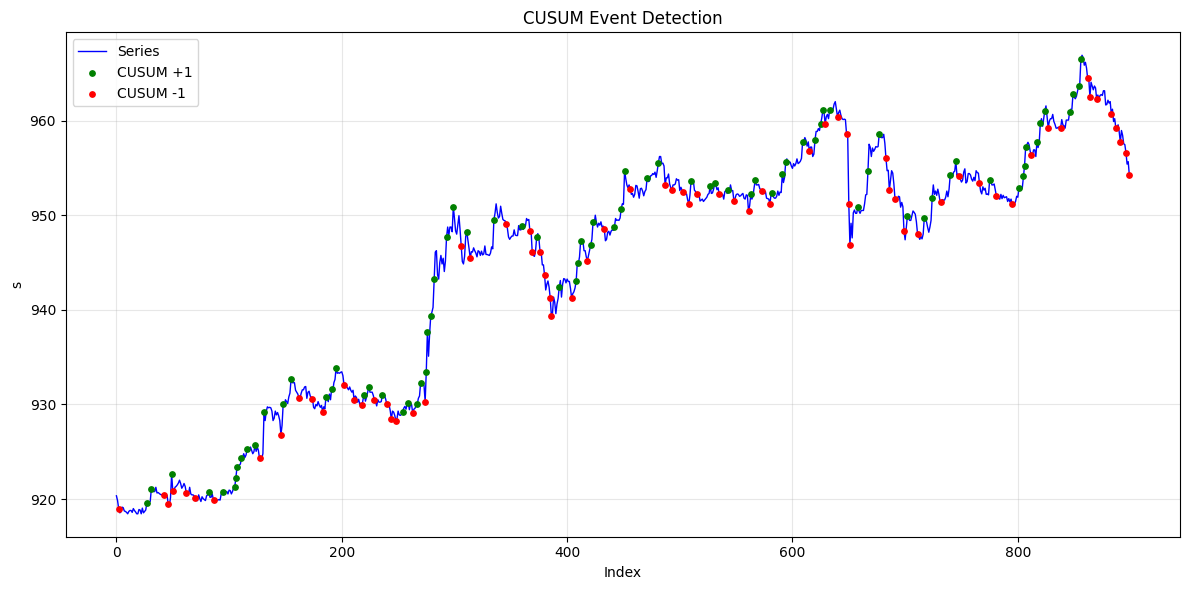

In [7]:
ds_c.plot_cusum_result(s=df["open"], cusum=df["selected"])

In [8]:
# auto square-off timings for open intraday positions is 3:20 PM
# https://support.zerodha.com/category/trading-and-markets/trading-faqs/market-sessions/articles/intraday-auto-square-off-timings
# 3:20 PM IST is 9:50 AM UTC
# Using 9:47 AM UTC to have a buffer
df["position_allowed"] = df.index.time <= dt.time(9, 47)

In [9]:
df["selected_with_position_allowed"] = ds_c.cusum(
  s=np.log(df["open"]),
  thresholds=m * df["vol"],
  position_allowed=df["position_allowed"],
).squeeze()
df["selected_with_position_allowed"].value_counts(dropna=False)

selected_with_position_allowed
 0    756
 1     77
-1     67
Name: count, dtype: int64

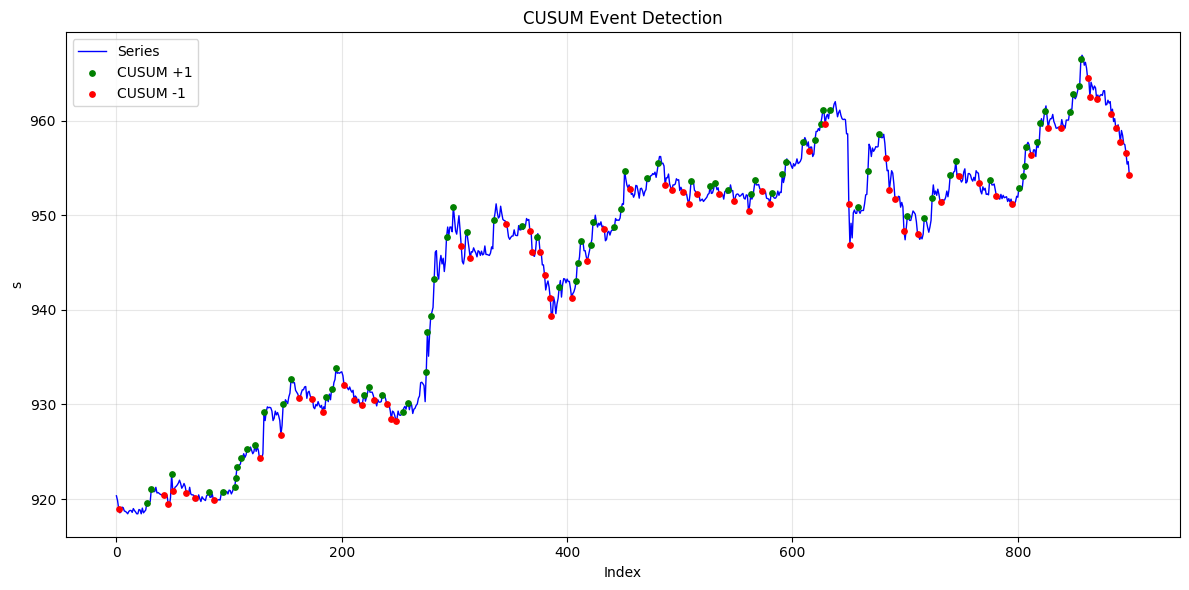

In [10]:
ds_c.plot_cusum_result(s=df["open"], cusum=df["selected_with_position_allowed"])